In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
data_path = './evaluation'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [3]:
import argparse
import os
import sys
import torch
import tqdm
import cv2
import numpy as np
sys.path.append('detectron2')

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, default_setup, launch
from detectron2.evaluation import COCOEvaluator, verify_results

from utils.utils import mkdir, save_features
from utils.extract_utils import get_image_blob
from models.bua import add_bottom_up_attention_config
from models.bua.layers.nms import nms

In [4]:
config_file = 'configs/bua-caffe/extract-bua-caffe-r101.yaml'

cfg = get_cfg()
add_bottom_up_attention_config(cfg, True)
cfg.merge_from_file(config_file)
cfg.freeze()

Config 'configs/bua-caffe/extract-bua-caffe-r101.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [5]:
MIN_BOXES = 10
MAX_BOXES = 20
CONF_THRESH = 0.4

model = DefaultTrainer.build_model(cfg)
DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
    cfg.MODEL.WEIGHTS, resume=True
)
model.eval()

GeneralizedBUARCNN(
  (backbone): ResNet(
    (stem): BUABasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
      )
      (1): Bottleneck

boxes=20


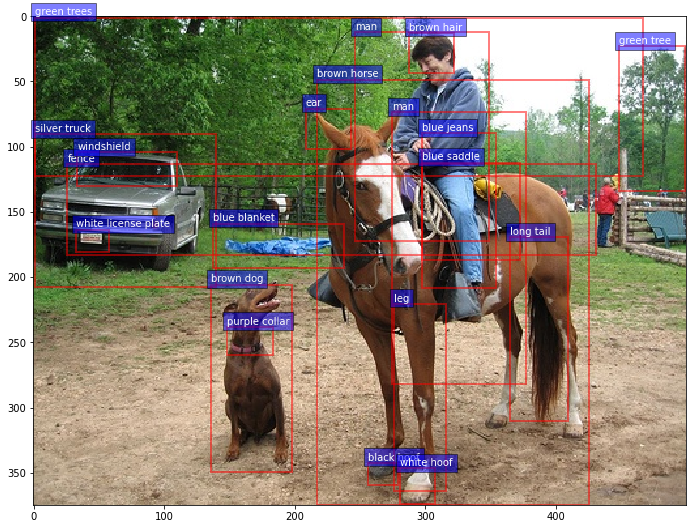

In [10]:
im_file = 'datasets/demo/004545.jpg'

im = cv2.imread(im_file)
dataset_dict = get_image_blob(im)

with torch.set_grad_enabled(False):
    boxes, scores, features_pooled, attr_scores = model([dataset_dict])

dets = boxes[0].tensor.cpu() / dataset_dict['im_scale']
scores = scores[0].cpu()
feats = features_pooled[0].cpu()
attr_scores = attr_scores[0].cpu()

max_conf = torch.zeros((scores.shape[0])).to(scores.device)
for cls_ind in range(1, scores.shape[1]):
        cls_scores = scores[:, cls_ind]
        keep = nms(dets, cls_scores, 0.3)
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep],
                                    cls_scores[keep],
                                    max_conf[keep])
            
keep_boxes = torch.nonzero(max_conf >= CONF_THRESH).flatten()
if len(keep_boxes) < MIN_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MIN_BOXES]
elif len(keep_boxes) > MAX_BOXES:
    keep_boxes = torch.argsort(max_conf, descending=True)[:MAX_BOXES]

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = dets[keep_boxes].numpy()
objects = np.argmax(scores[keep_boxes].numpy()[:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_scores[keep_boxes].numpy()[:,1:], axis=1)
attr_conf = np.max(attr_scores[keep_boxes].numpy()[:,1:], axis=1)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print('boxes={}'.format(len(keep_boxes)))